In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
kernel_size = 3
in_channels = 2
out_channels = 2

In [3]:
# Kernel definitions
k_edge_detector = np.array([
    [-1, -1, -1],
    [-1,  8, -1],
    [-1, -1, -1]
])
k_blur = np.array([
    [1, 2, 1],
    [2, 4, 2],
    [1, 2, 1]
])
k_sharpen = np.array([
    [0, -1, 0],
    [-1, 5, -1],
    [0, -1, 0]
])
k_identity = np.array([
    [0, 0, 0],
    [0, 1, 0],
    [0, 0, 0]
])
kernels_channel_indexed = {
    0: [k_edge_detector, k_blur],
    1: [k_sharpen, k_identity]
}

In [4]:
def get_kernel_weights(
    input_channel: int,
    kernel_index: int = 0,
    kernel_memory: dict = kernels_channel_indexed
):
    channel_kernels = kernel_memory[input_channel]

    weights = [0] * len(channel_kernels)

    for idx, kernel in enumerate(channel_kernels):
        
        weights[idx] = kernel.flatten()[kernel_index]

    return weights

get_kernel_weights(input_channel=0, kernel_index=0)

[-1, 1]

In [5]:
def generate_simple_kernel_file(output_file="kernel_weights.mem"):
    """Generate BRAM file for your existing kernels - quick and simple!"""
    
    print(f"Generating {output_file} for visual comparison...")
    
    with open(output_file, 'w') as f:
        f.write("// Simple kernel weights for visual inspection\n")
        f.write("// Input channels: 0, 1\n") 
        f.write("// Output channels: 2 each (edge_detector+blur, sharpen+identity)\n")
        f.write("//\n")
        
        # Process each input channel
        for in_ch in [0, 1]:
            f.write(f"// Input Channel {in_ch}\n")
            
            # Process all 9 kernel positions (3x3)
            for pos in range(9):
                address = in_ch * 9 + pos  # Your new addressing scheme
                weights = get_kernel_weights(in_ch, pos)
                
                # Convert to hex (assuming 6-bit signed, 2 output channels)
                hex_weights = []
                for w in weights:
                    if w < 0:
                        w_hex = w + 64  # Convert to 6-bit unsigned
                    else:
                        w_hex = w
                    hex_weights.append(w_hex)
                
                # Pack: output_ch0 in bits [5:0], output_ch1 in bits [11:6] 
                packed = hex_weights[0] | (hex_weights[1] << 6)
                
                row, col = divmod(pos, 3)
                f.write(f"@{address:03X} {packed:03X}  // pos({row},{col}) weights: {weights}\n")
            
            f.write("\n")
    
    print(f"Done! Use INIT_FILE=\"{output_file}\" in your kernel_bram")
    
    # Quick verification
    print("\nQuick check:")
    print("Channel 0, center position (pos 4):", get_kernel_weights(0, 4))
    print("Channel 1, center position (pos 4):", get_kernel_weights(1, 4))

generate_simple_kernel_file()

Generating kernel_weights.mem for visual comparison...
Done! Use INIT_FILE="kernel_weights.mem" in your kernel_bram

Quick check:
Channel 0, center position (pos 4): [8, 4]
Channel 1, center position (pos 4): [5, 1]


In [6]:
def convert_to_torch_weight(kernels_dict):
    input_channels = len(kernels_dict)
    output_channels = len(kernels_dict[0])
    
    torch_weights = torch.zeros(output_channels, input_channels, kernel_size, kernel_size)

    for input_channel in range(input_channels):
        for output_channel in range(output_channels):
            kernel = kernels_dict[input_channel][output_channel]
            torch_weights[output_channel, input_channel, :, :] = torch.from_numpy(kernel.astype(np.float32))

    return torch_weights 

convert_to_torch_weight(kernels_channel_indexed)

tensor([[[[-1., -1., -1.],
          [-1.,  8., -1.],
          [-1., -1., -1.]],

         [[ 0., -1.,  0.],
          [-1.,  5., -1.],
          [ 0., -1.,  0.]]],


        [[[ 1.,  2.,  1.],
          [ 2.,  4.,  2.],
          [ 1.,  2.,  1.]],

         [[ 0.,  0.,  0.],
          [ 0.,  1.,  0.],
          [ 0.,  0.,  0.]]]])

In [7]:
def create_torch_layer(kernels_dict):
    input_channels = len(kernels_dict)
    output_channels = len(kernels_dict[0])

    conv_layer = nn.Conv2d(
        in_channels=input_channels,
        out_channels=output_channels,
        kernel_size=kernel_size,
        padding=1,
        bias=False,
        padding_mode='zeros'
    )

    kernel_weights = convert_to_torch_weight(kernels_dict)
    conv_layer.weight.data = kernel_weights
    return conv_layer

conv = create_torch_layer(kernels_channel_indexed)

(8, 8, 2)


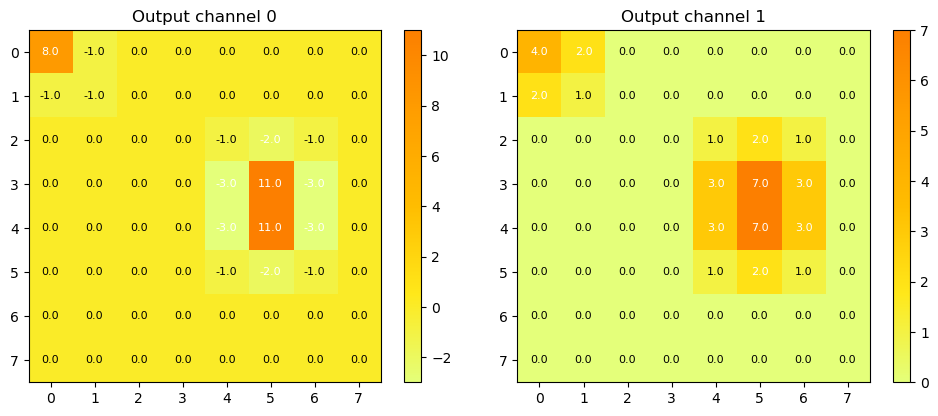

In [16]:
def sim_one_channel(
    in_channel_index: int,
    event_coord: tuple[int, int],
    image_dimensions: tuple[int, int],
    kernel_size: int = kernel_size,
    out_channels: int = out_channels,
):

    x, y = event_coord
    img_w, img_h = image_dimensions
    out_feature_maps = np.zeros((img_h, img_w, out_channels), dtype=np.float32)

    kernel_offset = kernel_size // 2
    for dx in range(-kernel_offset, kernel_offset+1):
        for dy in range(-kernel_offset, kernel_offset+1):
            kernel_position = (dx + kernel_offset) * kernel_size + (dy + kernel_offset)
            kernel_weights = np.array(get_kernel_weights(in_channel_index, kernel_position))
            #print(f"dx: {dx}, dy: {dy} => kernel_position: {kernel_position} => kernel vector weights: {kernel_weights}")

            #print(out_feature_maps[y + dy, x + dx, :]+ kernel_weights)
            if 0 <= x + dx < img_w and 0 <= y + dy < img_h:
                out_feature_maps[y + dy, x + dx, :] += kernel_weights
            

    return out_feature_maps

result = sim_one_channel(
    in_channel_index=1,
    event_coord=(5, 3),
    image_dimensions=(8,8),
    kernel_size=kernel_size,
    out_channels=out_channels
) + sim_one_channel(
    in_channel_index=0,
    event_coord=(5, 3),
    image_dimensions=(8, 8),
    kernel_size=kernel_size,
    out_channels=out_channels
) + sim_one_channel(
    in_channel_index=0,
    event_coord=(5, 4),
    image_dimensions=(8, 8),
    kernel_size=kernel_size,
    out_channels=out_channels
) + sim_one_channel(
    in_channel_index=1,
    event_coord=(5, 4),
    image_dimensions=(8, 8),
    kernel_size=kernel_size,
    out_channels=out_channels
) + sim_one_channel(
    in_channel_index=0,
    event_coord=(0,0),
    image_dimensions=(8, 8),
    kernel_size=kernel_size,
    out_channels=out_channels
)
print(result.shape)
# Plot each output channel
fig, axes = plt.subplots(1, out_channels, figsize=(5 * out_channels, 4))
if out_channels == 1:
    axes = [axes]
for ch in range(out_channels):
    ax = axes[ch]
    im = ax.imshow(result[:, :, ch], cmap='Wistia')
    ax.set_title(f"Output channel {ch}")
    fig.colorbar(im, ax=ax)
    # Print values on each cell
    for i in range(result.shape[0]):
        for j in range(result.shape[1]):
            val = result[i, j, ch]
            ax.text(j, i, f"{val:.1f}", ha='center', va='center', color='white' if abs(val) > 1 else 'black', fontsize=8)
plt.tight_layout()
plt.show()

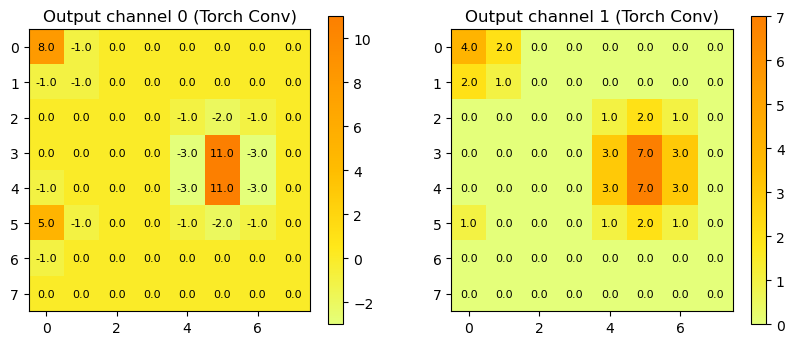

In [42]:
# Make an input image for torch conv layer
event_coord = (5, 3)  # Example event coordinate
event_coord2 =  (5, 4)  # Another event coordinate for the second channel
event_coord3 = (0, 0)  # Another event coordinate for the first channel
event_coord4 = (0, 5)
N, C_in, H, W = 1, in_channels, 8, 8
input_image = torch.zeros((N, C_in, H, W), dtype=torch.float32)
input_image[0, 1, event_coord[1], event_coord[0]] = 1.0  # Set the event at the specified coordinate
input_image[0, 0, event_coord[1], event_coord[0]] = 1.0  # Set the event for the second channel as well
input_image[0, 1, event_coord2[1], event_coord2[0]] += 1.0  # Set the second event for the second channel
input_image[0, 0, event_coord2[1], event_coord2[0]] += 1.0  # Set the second event for the first channel as well
input_image[0, 0, event_coord3[1], event_coord3[0]] += 1.0

#input_image[0, 1, event_coord3[1], event_coord3[0]] += 1.0  # Set the event for the first channel at (0, 0)
input_image[0, 1, event_coord4[1], event_coord4[0]] += 1.0  # Set the event for the first channel at (0, 5)

result = conv(input_image)
# Plot each output channel from the torch conv layer
fig, axes = plt.subplots(1, out_channels, figsize=(5 * out_channels, 4))
if out_channels == 1:
    axes = [axes]
for ch in range(out_channels):
    ax = axes[ch]
    im = ax.imshow(result[0, ch].detach().numpy(), cmap='Wistia')
    ax.set_title(f"Output channel {ch} (Torch Conv)")
    fig.colorbar(im, ax=ax)
    # Print values on each cell
    for i in range(result.shape[2]):
        for j in range(result.shape[3]):
            val = result[0, ch, i, j].item()
            ax.text(j, i, f"{val:.1f}", ha='center', va='center', color='black' if abs(val) > 1 else 'black', fontsize=8)

In [40]:
# conv_mem_parser.py

def twos_complement(val: int, bits: int) -> int:
    """
    Interpret `val` (0 ≤ val < 2**bits) as a signed two’s-complement
    number stored in `bits` bits.
    """
    if val & (1 << (bits - 1)):
        val -= (1 << bits)
    return val

def bram_to_feature_map_vector(
    bram_data: int,
    out_channels: int = 2,
    bits_per_neuron: int = 9
) -> list[int]:
    """
    Given the packed integer `bram_data` holding
      out_channels * bits_per_neuron
    bits (LSB = channel 0), extract a Python list of signed ints.
    """
    mask = (1 << bits_per_neuron) - 1
    fm = []
    for ch in range(out_channels):
        # Vivado: result[ch] = bram_data[ch*bits +: bits]
        raw = (bram_data >> (ch * bits_per_neuron)) & mask
        signed = twos_complement(raw, bits_per_neuron)
        fm.append(signed)
    return fm

def parse_feature_map_file(
    filepath: str,
    out_channels: int = 2,
    bits_per_neuron: int = 9,
    radix: str = 'hex'
) -> list[list[int]]:
    """
    Reads each line of `filepath`, interprets it as a single BRAM word
    (hex by default), and returns a list of feature-map vectors.
    """
    results = []
    with open(filepath, 'r', encoding='ascii') as f:
        for raw in f:
            line = raw.strip()
            if not line:
                continue
            # parse the line as an integer
            if radix.lower() == 'hex':
                bram_data = int(line, 16)
            elif radix.lower() == 'bin':
                bram_data = int(line, 2)
            else:
                raise ValueError("radix must be 'hex' or 'bin'")
            fm = bram_to_feature_map_vector(
                bram_data, out_channels, bits_per_neuron
            )
            results.append(fm)
    return results

FILE = r'E:\rtsprojects\multi_channel_conv\multi_channel_conv.sim\sim_1\behav\xsim\test_mem3.mem'

slices_per_line = parse_feature_map_file(
    FILE,
    out_channels=2,
    bits_per_neuron=6,
    radix='bin'
)
count = 0
for i, sl in enumerate(slices_per_line):
    if sl[0] != 0 or sl[1] != 0:
        print(f"Line {i}: {sl[0]} {sl[1]}")
        count += 1
print(f"Total non-zero lines: {count}")

Line 0: 8 4
Line 1: -1 2
Line 4: -1 0
Line 5: 5 1
Line 6: -1 0
Line 8: -1 2
Line 9: -1 1
Line 13: -1 0
Line 34: -1 1
Line 35: -3 3
Line 36: -3 3
Line 37: -1 1
Line 42: -2 2
Line 43: 11 7
Line 44: 11 7
Line 45: -2 2
Line 50: -1 1
Line 51: -3 3
Line 52: -3 3
Line 53: -1 1
Total non-zero lines: 20


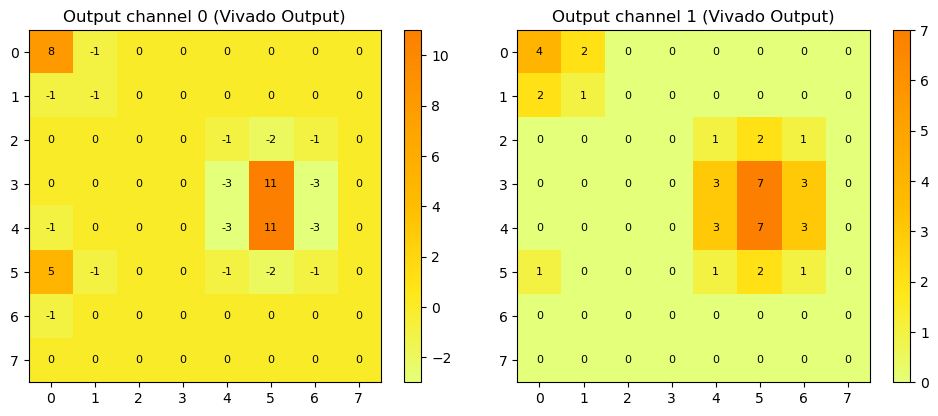

In [41]:
vivado_output = np.zeros((8, 8, 2), dtype=np.int16)
counter = 0
for w in range (0, 8):
    for h in range(0, 8):
        vivado_output[h, w, :] = slices_per_line[w * 8 + h]

# Plot each output channel from vivado_output
fig, axes = plt.subplots(1, out_channels, figsize=(5 * out_channels, 4))
if out_channels == 1:
    axes = [axes]
for ch in range(out_channels):
    ax = axes[ch]
    im = ax.imshow(vivado_output[:, :, ch], cmap='Wistia')
    ax.set_title(f"Output channel {ch} (Vivado Output)")
    fig.colorbar(im, ax=ax)
    # Print values on each cell
    for i in range(vivado_output.shape[0]):
        for j in range(vivado_output.shape[1]):
            val = vivado_output[i, j, ch]
            ax.text(j, i, f"{val}", ha='center', va='center', color='black' if abs(val) > 1 else 'black', fontsize=8)
plt.tight_layout()
plt.show()